# Rendu Projet Apprentissage pour l'Image
Nicolas ELFERING
Florent HARDY

Afin d'obtenir ~95% d'accuracy nous avons utilisé : 
 - le transfer learning (EfficientNetB1-7)
 - l'augmentation d'images (rotation et zoom)
 - le dropout (gel) de paramètres

Le plus grand problème auquel nous avons du faire face est le manque de mémoire / les fuites de mémoire.
En effet dès l'initialisation du modèle, l'ensemble des images prend environ 10 gigaoctets de RAM, signifiant que l'augmentation doit se faire dans second temps sinon la machine n'a plus assez de mémoire pour continuner l'exécution.

Les modèles EfficientNet varient de version où 0 a 6 millions de paramètres, 4 en a 19 millions et 7 66 millions. Il était nécessaire d'utiliser un modèle qui ne surcharge pas la mémoire du GPU, nous nous sommes arrêtés à la version 4 qui remplissait 95% de la mémoire du GPU.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

csv_path = "/kaggle/input/2024-competion-asi-i-3-d/train.csv"
df = pd.read_csv(csv_path)

df['filepath'] = df['ID'].apply(lambda x: os.path.join('/kaggle/input/2024-competion-asi-i-3-d/train/', str(x) + ".png"))

categories = sorted(df['Category'].unique())
category_to_index = {cat: idx for idx, cat in enumerate(categories)}
df['label'] = df['Category'].map(category_to_index)

print(df)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=420)

          ID  Category                                           filepath  \
0          3         0  /kaggle/input/2024-competion-asi-i-3-d/train/3...   
1          4         0  /kaggle/input/2024-competion-asi-i-3-d/train/4...   
2          6         1  /kaggle/input/2024-competion-asi-i-3-d/train/6...   
3          7         0  /kaggle/input/2024-competion-asi-i-3-d/train/7...   
4          8         0  /kaggle/input/2024-competion-asi-i-3-d/train/8...   
...      ...       ...                                                ...   
13995  19993         3  /kaggle/input/2024-competion-asi-i-3-d/train/1...   
13996  19997         0  /kaggle/input/2024-competion-asi-i-3-d/train/1...   
13997  19998         2  /kaggle/input/2024-competion-asi-i-3-d/train/1...   
13998  20000         1  /kaggle/input/2024-competion-asi-i-3-d/train/2...   
13999  20001         0  /kaggle/input/2024-competion-asi-i-3-d/train/2...   

       label  
0          0  
1          0  
2          1  
3          0  


Ici nous définissons la fonction d'augmentation des images qui choisit une rotation aléatoire entre 0, 1, 2 ou 3 rotations de 90°
Et un zoom aléatoire entre 0.8, 0.9 et 1. L'image doit être resize après le zoom afin de correspondre à la taille du vecteur d'entrée du modèle.

Les images sont "normalisées" en flottants entre 0.0 et 1.0 afin de correspondre aux fonctions d'activation du modèle.
Les labels sont encodés en one-hot.

In [3]:
def augment_image(img):
    # Random rotation
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random zoom
    scales = [0.8, 0.9, 1.0]  # Zoom scales
    scale = tf.random.shuffle(scales)[0]
    original_shape = tf.shape(img)[:2]
    new_shape = tf.cast(tf.cast(original_shape, tf.float32) * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = tf.image.resize_with_crop_or_pad(img, original_shape[0], original_shape[1])
    
    return img

def preprocess_image(filepath, label, augment=False):
    # Load the image
    img = tf.io.read_file(filepath)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [256, 256])
    
    if augment:
        img = augment_image(img)
    
    img = img / 255.0
    
    label = tf.one_hot(label, depth=len(categories))
    
    return img, label

def create_dataset(dataframe, augment=False):
    filepaths = dataframe['filepath'].values
    labels = dataframe['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(dataframe)).batch(16)
    return dataset

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

Nous utilisons le modèle EfficientNetB4 qui est un modèle de classification d'images, pour faire du transfer learning. L'architecture d'EfficientNetB4 peut être trouvée ici https://arxiv.org/pdf/1905.11946v3 dans l'article "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" rédigé par Mingxing Tan et Quoc V. Le

Le modèle a déjà été entraîné sur l'ensemble d'images "imagenet", nous importons donc les poids pré-entraînés pour les réutiliser. Les mitochondries entourées de cytoplasmes sont plus ou moins aussi classifiables qu'une giraffe entourée d'arbres. 

Nous ajoutons une couche de pooling pour passer d'un vecteur d'entrée de taile 256x256x3 à 256x256x1 (rgb à nuances de gris).
Nous ajoutons une couche de dropout afin d'éviter le sur-entraînement.

Nous faisons passer 10 époques des images de base non augmentées et 4 itérations d'images augmentées.
Nous tentons également de libérer de l'espace mémoire après chaque époque en forçant le garbage collector à supprimer les variables inutilisées et en vidant le GPU en vidant la session tensorflow.

In [4]:
import gc
import tensorflow.keras.backend as K

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models

class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        K.clear_session()

base_model = EfficientNetB4(
    include_top=False,  
    weights='imagenet', 
    input_shape=(256, 256, 3)
)

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[ClearMemoryCallback()])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 315s 223ms/step - accuracy: 0.7351 - loss: 0.7048 - val_accuracy: 0.7182 - val_loss: 0.7419
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 165s 208ms/step - accuracy: 0.8924 - loss: 0.2937 - val_accuracy: 0.9068 - val_loss: 0.2579
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 164s 208ms/step - accuracy: 0.9276 - loss: 0.2180 - val_accuracy: 0.9200 - val_loss: 0.2212
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.9439 - loss: 0.1726 - val_accuracy: 0.9307 - val_loss: 0.1985
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.9623 - loss: 0.1274 - val_accuracy: 0.9382 - val_loss: 0.1855
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 165s 209ms/step - accuracy: 0.9601 - loss: 0.1281 - val_accuracy: 0.9054 - val_loss: 0.3001
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.9711 - loss: 0.0957 - val_accuracy: 0.8879 - val_loss: 0.3482
Epoch 8/10
700/700 ━━━━━━

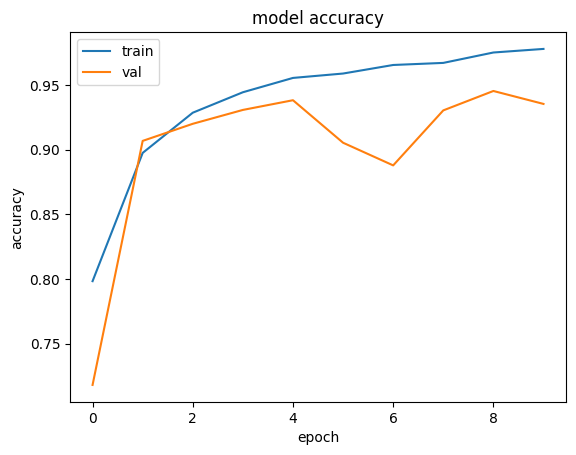

In [5]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 246s 209ms/step - accuracy: 0.8839 - loss: 0.3533 - val_accuracy: 0.9661 - val_loss: 0.0935
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 208ms/step - accuracy: 0.9358 - loss: 0.1947 - val_accuracy: 0.9643 - val_loss: 0.1021
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 209ms/step - accuracy: 0.9469 - loss: 0.1631 - val_accuracy: 0.9639 - val_loss: 0.1003
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 209ms/step - accuracy: 0.9519 - loss: 0.1465 - val_accuracy: 0.9143 - val_loss: 0.2513
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 209ms/step - accuracy: 0.9505 - loss: 0.1508 - val_accuracy: 0.9443 - val_loss: 0.1692
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 209ms/step - accuracy: 0.9486 - loss: 0.1532 - val_accuracy: 0.9657 - val_loss: 0.1064
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 209ms/step - accuracy: 0.9607 - loss: 0.1218 - val_accuracy: 0.9568 - val_loss: 0.1266
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 209ms/step - accuracy: 0.9518 -

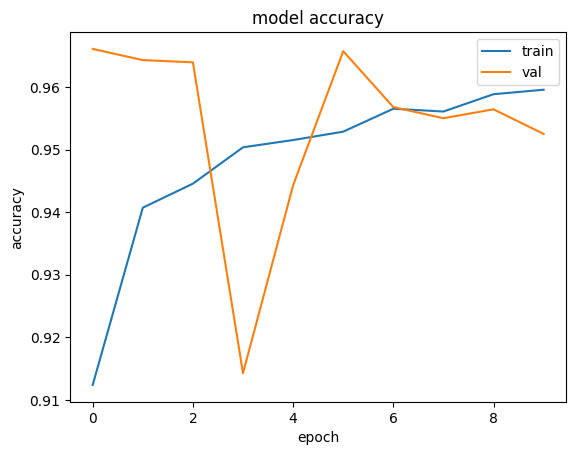

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=421)
train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[ClearMemoryCallback()])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 208ms/step - accuracy: 0.9569 - loss: 0.1263 - val_accuracy: 0.9668 - val_loss: 0.0969
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 210ms/step - accuracy: 0.9653 - loss: 0.1101 - val_accuracy: 0.9621 - val_loss: 0.1104
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 209ms/step - accuracy: 0.9611 - loss: 0.1114 - val_accuracy: 0.9607 - val_loss: 0.1243
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 165s 205ms/step - accuracy: 0.9641 - loss: 0.1096 - val_accuracy: 0.9554 - val_loss: 0.1225
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 207ms/step - accuracy: 0.9663 - loss: 0.1044 - val_accuracy: 0.9571 - val_loss: 0.1184
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 163s 204ms/step - accuracy: 0.9628 - loss: 0.1115 - val_accuracy: 0.9632 - val_loss: 0.1119
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 163s 204ms/step - accuracy: 0.9659 - loss: 0.1072 - val_accuracy: 0.9629 - val_loss: 0.1100
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 165s 207ms/step - accuracy: 0.9641 -

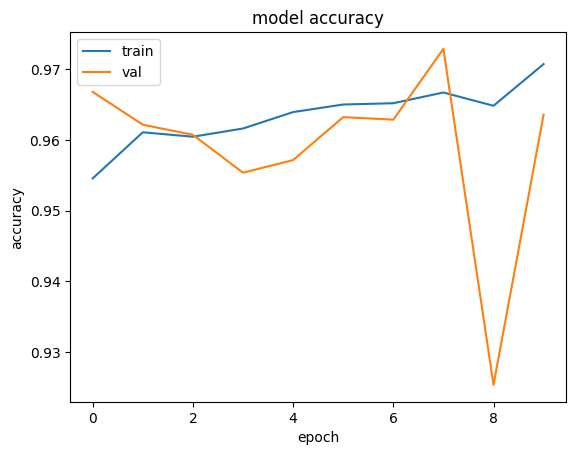

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=422)
train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[ClearMemoryCallback()])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 165s 207ms/step - accuracy: 0.9695 - loss: 0.0927 - val_accuracy: 0.9650 - val_loss: 0.0965
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 207ms/step - accuracy: 0.9723 - loss: 0.0846 - val_accuracy: 0.9425 - val_loss: 0.1631
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 207ms/step - accuracy: 0.9758 - loss: 0.0828 - val_accuracy: 0.9650 - val_loss: 0.1105
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 207ms/step - accuracy: 0.9769 - loss: 0.0764 - val_accuracy: 0.9696 - val_loss: 0.0997
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 208ms/step - accuracy: 0.9735 - loss: 0.0825 - val_accuracy: 0.9725 - val_loss: 0.0822
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 208ms/step - accuracy: 0.9748 - loss: 0.0764 - val_accuracy: 0.9632 - val_loss: 0.0970
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 208ms/step - accuracy: 0.9769 - loss: 0.0754 - val_accuracy: 0.9618 - val_loss: 0.1069
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 209ms/step - accuracy: 0.9760 -

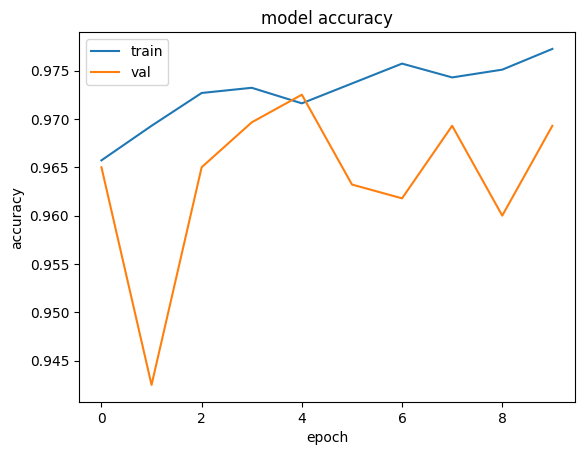

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=423)
train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[ClearMemoryCallback()])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 209ms/step - accuracy: 0.9723 - loss: 0.0800 - val_accuracy: 0.9764 - val_loss: 0.0592
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 167s 208ms/step - accuracy: 0.9773 - loss: 0.0690 - val_accuracy: 0.9750 - val_loss: 0.0819
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 210ms/step - accuracy: 0.9783 - loss: 0.0696 - val_accuracy: 0.9700 - val_loss: 0.0795
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 210ms/step - accuracy: 0.9779 - loss: 0.0695 - val_accuracy: 0.9704 - val_loss: 0.0834
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 208ms/step - accuracy: 0.9759 - loss: 0.0717 - val_accuracy: 0.9693 - val_loss: 0.0906
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 210ms/step - accuracy: 0.9747 - loss: 0.0738 - val_accuracy: 0.9668 - val_loss: 0.0951
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 166s 206ms/step - accuracy: 0.9821 - loss: 0.0553 - val_accuracy: 0.9782 - val_loss: 0.0705
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 165s 206ms/step - accuracy: 0.9799 -

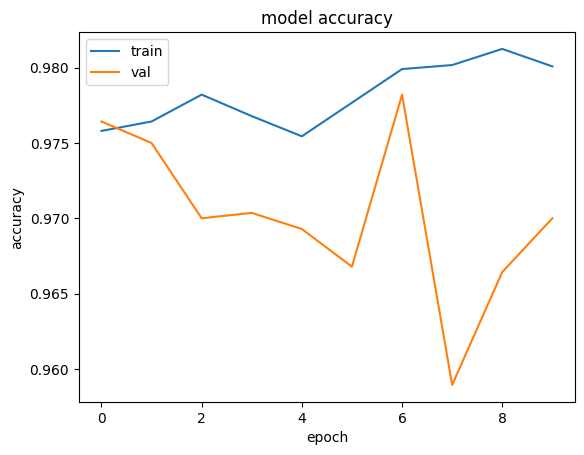

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=424)
train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[ClearMemoryCallback()])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [10]:
test_images_path = "/kaggle/input/2024-competion-asi-i-3-d/test/"

def preprocess_test_image(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_png(img, channels=1) 
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0 
    return img

def create_test_dataset(image_folder):
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(".png")]

    ids = [int(os.path.splitext(os.path.basename(path))[0]) for path in image_paths]

    sorted_data = sorted(zip(ids, image_paths), key=lambda x: x[0])
    ids, image_paths = zip(*sorted_data)

    dataset = tf.data.Dataset.from_tensor_slices(list(image_paths))
    dataset = dataset.map(preprocess_test_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset, ids

def predict_and_create_csv(model, test_images_path, output_path):
    test_dataset, test_ids = create_test_dataset(test_images_path)

    predictions = model.predict(test_dataset)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    submission_df = pd.DataFrame({
        "ID": test_ids,
        "Category": predicted_classes
    })

    submission_df.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")

predict_and_create_csv(model, test_images_path, output_path="/kaggle/working/submission.csv")



188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step
Submission file saved to /kaggle/working/submission.csv
